# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
import os
from collections import namedtuple
pd.set_option("display.max_rows",35)
%matplotlib inline

In [2]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    
    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [3]:
dataset.kdd_train_2labels.shape

(125973, 124)

In [4]:
dataset.kdd_test_2labels.shape

(22544, 124)

In [5]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Attack','is_Normal']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]

    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)

    y_train = y_output.values
    y_test = y_test.values

preprocess.x_train.shape

(125973, 122)

In [6]:
import tensorflow as tf


In [7]:
class network(object):
    
    input_dim = 122
    classes = 2
    hidden_encoder_dim = 122
    hidden_layers = 1
    latent_dim = 18

    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            
            #hidden_encoder = tf.layers.dense(self.x, latent_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            #hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            
        with tf.variable_scope("Layer_Dense_Softmax"):
            self.y = tf.layers.dense(hidden_encoder, classes, activation=tf.nn.softmax)
            
        with tf.variable_scope("Loss"):
            
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.y_, logits = self.y))

            #loss = tf.clip_by_value(loss, -1e-1, 1e-1)
            #loss = tf.where(tf.is_nan(loss), 1e-1, loss)
            #loss = tf.where(tf.equal(loss, -1e-1), tf.random_normal(loss.shape), loss)
            #loss = tf.where(tf.equal(loss, 1e-1), tf.random_normal(loss.shape), loss)
            
            self.regularized_loss = loss
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate=1e-5
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [10]:
import collections
import time

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score', 'time_taken'])

    predictions = {}

    results = []
    best_acc = 0
    best_acc_global = 0
    
    def train(epochs, net, h,f):
        batch_iterations = 200
        train_loss = None
        Train.best_acc = 0
        os.makedirs("dataset/tf_dense_only_nsl_kdd/hidden layers_{}_features count_{}".format(epochs,h,f),
                    exist_ok = True)
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            start_time = time.perf_counter()

            for epoch in range(1, (epochs+1)):
                x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                          preprocess.y_train, 
                                                                          test_size=0.1)
                batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                           batch_iterations)
                                                                          
                for i in batch_indices:
                    
                    def train_batch():
                        nonlocal train_loss
                        _, train_loss = sess.run([net.train_op, 
                                                           net.regularized_loss, 
                                                           ], #net.summary_op
                                                          feed_dict={net.x: x_train[i,:], 
                                                                     net.y_: y_train[i,:], 
                                                                     net.keep_prob:0.5})
                    
                    train_batch()
                    #summary_writer_train.add_summary(summary_str, epoch)
                    while((train_loss > 1e4 or np.isnan(train_loss)) and epoch > 1):
                        print("Step {} | Training Loss: {:.6f}".format(epoch, train_loss))
                        net.saver.restore(sess, 
                                          tf.train.latest_checkpoint('dataset/tf_dense_only_nsl_kdd/hidden_layers_{}_features_count_{}'
                                                                     .format(epochs,h,f)))
                        train_batch()
                    

                valid_accuracy = sess.run(net.tf_accuracy, #net.summary_op 
                                                      feed_dict={net.x: x_valid, 
                                                                 net.y_: y_valid, 
                                                                 net.keep_prob:1})
                #summary_writer_valid.add_summary(summary_str, epoch)

                
                accuracy, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, 
                                                               net.pred, 
                                                               net.actual, net.y], 
                                                              feed_dict={net.x: preprocess.x_test, 
                                                                         net.y_: preprocess.y_test, 
                                                                         net.keep_prob:1})

                print("Step {} | Training Loss: {:.6f} | Validation Accuracy: {:.6f}".format(epoch, train_loss, valid_accuracy))
                print("Accuracy on Test data: {}".format(accuracy))

                if accuracy > Train.best_acc_global:
                    Train.best_acc_global = accuracy
                    Train.pred_value = pred_value
                    Train.actual_value = actual_value
                    Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)

                if accuracy > Train.best_acc:
                    Train.best_acc = accuracy
                    
                    if not (np.isnan(train_loss)):
                        net.saver.save(sess, 
                                   "dataset/tf_dense_only_nsl_kdd/hidden_layers_{}_features_count_{}".format(h,f),
                                    global_step = epochs)
                    curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value})
                    Train.predictions.update({"{}_{}_{}".format(epochs,f,h):(curr_pred, 
                                               Train.result(epochs, f, h,valid_accuracy, accuracy, time.perf_counter() - start_time))})

                    #Train.results.append(Train.result(epochs, f, h,valid_accuracy, accuracy))
            

In [11]:
import itertools
class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]
    features_arr = [4, 8, 32, 64]
    hidden_layers_arr = [2, 4, 6]

    epochs = [20]
    
    for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
        print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
        n = network(2,h,f)
        n.build_layers()
        Train.train(e, n, h,f)
        

Current Layer Attributes - epochs:20 hidden layers:2 features count:4
Step 1 | Training Loss: 0.663410 | Validation Accuracy: 0.696460
Accuracy on Test data: 0.7773243188858032
Step 2 | Training Loss: 0.661624 | Validation Accuracy: 0.823940
Accuracy on Test data: 0.8376951813697815
Step 3 | Training Loss: 0.648470 | Validation Accuracy: 0.835371
Accuracy on Test data: 0.8266057372093201
Step 4 | Training Loss: 0.641668 | Validation Accuracy: 0.848150
Accuracy on Test data: 0.8240330219268799
Step 5 | Training Loss: 0.638921 | Validation Accuracy: 0.864344
Accuracy on Test data: 0.8204400539398193
Step 6 | Training Loss: 0.631525 | Validation Accuracy: 0.881648
Accuracy on Test data: 0.8215933442115784
Step 7 | Training Loss: 0.635580 | Validation Accuracy: 0.896888
Accuracy on Test data: 0.820262610912323
Step 8 | Training Loss: 0.620816 | Validation Accuracy: 0.913161
Accuracy on Test data: 0.8203513026237488
Step 9 | Training Loss: 0.610219 | Validation Accuracy: 0.919035
Accuracy o

Step 15 | Training Loss: 0.387070 | Validation Accuracy: 0.963169
Accuracy on Test data: 0.8036284446716309
Step 16 | Training Loss: 0.381044 | Validation Accuracy: 0.967296
Accuracy on Test data: 0.7928495407104492
Step 17 | Training Loss: 0.382578 | Validation Accuracy: 0.965868
Accuracy on Test data: 0.7841110825538635
Step 18 | Training Loss: 0.368834 | Validation Accuracy: 0.966661
Accuracy on Test data: 0.7803406715393066
Step 19 | Training Loss: 0.368596 | Validation Accuracy: 0.966185
Accuracy on Test data: 0.7758162021636963
Step 20 | Training Loss: 0.381695 | Validation Accuracy: 0.966106
Accuracy on Test data: 0.7737313508987427
Current Layer Attributes - epochs:20 hidden layers:4 features count:4
Step 1 | Training Loss: 0.675782 | Validation Accuracy: 0.466423
Accuracy on Test data: 0.5479063391685486
Step 2 | Training Loss: 0.677014 | Validation Accuracy: 0.587871
Accuracy on Test data: 0.6271735429763794
Step 3 | Training Loss: 0.669848 | Validation Accuracy: 0.798857
Acc

Step 9 | Training Loss: 0.525209 | Validation Accuracy: 0.944991
Accuracy on Test data: 0.8164034485816956
Step 10 | Training Loss: 0.497437 | Validation Accuracy: 0.948166
Accuracy on Test data: 0.8171575665473938
Step 11 | Training Loss: 0.467538 | Validation Accuracy: 0.951897
Accuracy on Test data: 0.8167583346366882
Step 12 | Training Loss: 0.457477 | Validation Accuracy: 0.951976
Accuracy on Test data: 0.8168026804924011
Step 13 | Training Loss: 0.457929 | Validation Accuracy: 0.955866
Accuracy on Test data: 0.8162704110145569
Step 14 | Training Loss: 0.446968 | Validation Accuracy: 0.956898
Accuracy on Test data: 0.815693736076355
Step 15 | Training Loss: 0.418268 | Validation Accuracy: 0.958089
Accuracy on Test data: 0.8140968680381775
Step 16 | Training Loss: 0.433654 | Validation Accuracy: 0.962772
Accuracy on Test data: 0.8129435777664185
Step 17 | Training Loss: 0.416211 | Validation Accuracy: 0.960787
Accuracy on Test data: 0.8115241527557373
Step 18 | Training Loss: 0.402

Step 3 | Training Loss: 0.689343 | Validation Accuracy: 0.792427
Accuracy on Test data: 0.8211941123008728
Step 4 | Training Loss: 0.707720 | Validation Accuracy: 0.820686
Accuracy on Test data: 0.8281582593917847
Step 5 | Training Loss: 0.679009 | Validation Accuracy: 0.843070
Accuracy on Test data: 0.8416873812675476
Step 6 | Training Loss: 0.669693 | Validation Accuracy: 0.853548
Accuracy on Test data: 0.8496717810630798
Step 7 | Training Loss: 0.641692 | Validation Accuracy: 0.882918
Accuracy on Test data: 0.8736249208450317
Step 8 | Training Loss: 0.636748 | Validation Accuracy: 0.901334
Accuracy on Test data: 0.8810326457023621
Step 9 | Training Loss: 0.623175 | Validation Accuracy: 0.906096
Accuracy on Test data: 0.8808995485305786
Step 10 | Training Loss: 0.625877 | Validation Accuracy: 0.918638
Accuracy on Test data: 0.8755766749382019
Step 11 | Training Loss: 0.606653 | Validation Accuracy: 0.928719
Accuracy on Test data: 0.8745120763778687
Step 12 | Training Loss: 0.625711 |

In [12]:
dict1 = {}
dict2 = []
for k, (v1, v2) in Train.predictions.items():
    dict1.update({k: v1})
    dict2.append(v2)

In [13]:
Train.predictions = dict1
Train.results = dict2

In [14]:
df_results = pd.DataFrame(Train.results)

In [15]:
df_results.sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score,time_taken
6,20,32,4,0.892046,0.897933,19.431615
5,20,8,4,0.869027,0.885823,22.556436
1,20,8,2,0.905382,0.881254,17.043705
11,20,64,6,0.901334,0.881033,39.989143
3,20,64,2,0.919432,0.862757,8.935693
0,20,4,2,0.943007,0.845369,16.299912
4,20,4,4,0.850294,0.835788,9.173420
10,20,32,6,0.945309,0.829755,78.154274
7,20,64,4,0.948166,0.817158,39.293368
2,20,32,2,0.956342,0.788769,21.211315


In [16]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_dense_only_nsl_kdd_predictions.pkl")
df_results.to_pickle("dataset/tf_dense_only_nsl_kdd_scores.pkl")

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix
    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, preprocess.output_columns_2labels, normalize = True,
                         title = Train.best_parameters)

Normalized confusion matrix
[[ 0.9312  0.0688]
 [ 0.146   0.854 ]]


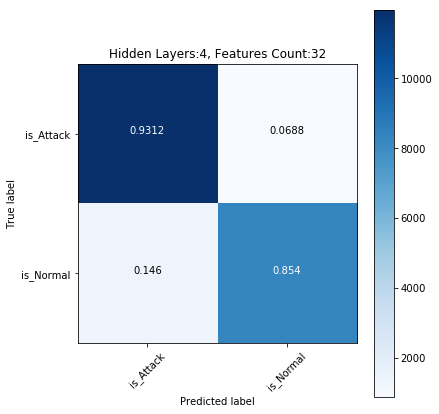

In [18]:
plot(actual_value = Train.actual_value, pred_value = Train.pred_value)